# Домашнее задание. Решение конкурса на kaggle.com


<a name="b"> </a>

### Оглавление

<a href=#1> 1. Исследование</a><br>
<a href=#2> 2. Загрузка и обработка тестовых данных</a><br>
<a href=#3> 3. Логистическая регрессия</a><br>
<a href=#4> 4. Лес</a><br>
<a href=#5> 5. Градиентный бустинг </a><br>
<a href=#6> Финальный результат </a><br>


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

sns.set()

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, power_transform
from category_encoders import TargetEncoder, MEstimateEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from catboost import CatBoostClassifier, Pool, cv

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

<a name="1"> </a>   
# 1. Исследование
<a href="#b"> назад </a> 

### Загрузка данных (2 балла)

In [3]:
DATAPATH = './kgl-comp-data/' #'/kaggle/input/advanced-dls-spring-2021/'

In [4]:
data = pd.read_csv(DATAPATH+'train.csv')

In [5]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [7]:
data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
3561,12,85.15,979.05,Female,0,No,No,Yes,No,Fiber optic,Yes,No,No,No,Yes,No,One year,Yes,Credit card (automatic),0
2678,72,84.20,5986.55,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),0
3962,2,56.55,118.25,Female,1,No,No,Yes,Yes,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Credit card (automatic),0
663,22,59.05,1253.5,Female,0,No,No,Yes,Yes,DSL,Yes,No,No,Yes,No,No,Month-to-month,Yes,Mailed check,0
4743,59,76.45,4519.5,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Mailed check,0


Поле TotalSpent записано как object, хотя на самом деле это число. Преобразуем...

In [8]:
data['TotalSpent'] = pd.to_numeric(data.TotalSpent.str.strip())

Теперь посмотрим на пропуски...

In [9]:
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  9
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [10]:
data[data['TotalSpent'].isna()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,NaN,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,NaN,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,NaN,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,NaN,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [11]:
data.query('ClientPeriod == 1')[['TotalSpent', 'MonthlySpending']]

,TotalSpent,MonthlySpending
2,75.90,75.90
7,45.70,45.70
51,74.45,74.45
63,48.45,48.45
67,24.40,24.40
...,...,...
5192,69.65,69.65
5199,19.70,19.70
5257,19.20,19.20
5265,85.80,85.80


NaN в TotalSpending - это новые клиенты. Можно заменить NaN на 0 или иное какое малое число, например, на половину от месячных расходов. 
Заполним пропуски, а потом посмотрим на дубликаты:

In [12]:
#заполним половиной месячного расхода
data.loc[data['TotalSpent'].isna(), 'TotalSpent'] = data.loc[data['TotalSpent'].isna(), 'MonthlySpending'] /2
data[data.ClientPeriod == 0]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,12.875,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,36.675,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,9.850,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,40.425,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,10.000,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,30.950,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,12.675,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,26.275,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,28.025,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [13]:
data.duplicated().sum() #есть 14 полностью дублированных строк. Удалим их (дубли).

14

In [14]:
data.drop_duplicates(inplace=True)

#теперь посмотрим, не осталось ли дубликатов, если отбросить целевой признак.
data[data.drop(['Churn'], axis=1).duplicated(keep=False)].sort_values(by=[*data.columns])

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
838,1,19.65,19.65,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
4811,1,19.65,19.65,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,1
3463,1,19.75,19.75,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
4294,1,19.75,19.75,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,1
3831,1,20.00,20.00,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
1647,1,20.00,20.00,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,1
3735,1,20.20,20.20,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
3769,1,20.20,20.20,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,1
881,1,20.40,20.40,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
1874,1,20.40,20.40,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,1


Осталось еще несколько дубликатов, различающихся по целевому признаку. Вся путаница в первом месяце, причем запись с Churn=1 позже, т.е. можно предположить, что информация о покупке еще не убрана из базы. Т.е. лучше оставить записи с Churn=1.

In [15]:
data.drop_duplicates(subset=list(data.columns[:-1]), keep='last', inplace=True)

Заметим, что признак IsSeniorCitizen хранится как число, хотя по сути он категориальный. 
Но это не мешает.

Посмотрим базовые статистики по столбцам

In [16]:
data.describe()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
count,5260.000000,5260.000000,5260.000000,5260.000000,5260.000000
mean,32.528327,65.040875,2296.937662,0.159886,0.260646
std,24.517317,30.153470,2269.067506,0.366535,0.439029
min,0.000000,18.250000,9.850000,0.000000,0.000000
25%,9.000000,35.737500,403.300000,0.000000,0.000000
50%,29.000000,70.500000,1414.900000,0.000000,0.000000
75%,55.000000,90.050000,3813.712500,0.000000,1.000000
max,72.000000,118.750000,8684.800000,1.000000,1.000000


In [17]:
data.describe(include=['O'])

,Sex,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
count,5260,5260,5260,5260,5260,5260,5260,5260,5260,5260,5260,5260,5260,5260,5260
unique,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4
top,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
freq,2644,2683,3654,4739,2489,2335,2603,2323,2308,2595,2090,2072,2898,3139,1780


Больше никаких аномалий в данных на этом этапе не заметно.

## Анализ данных 

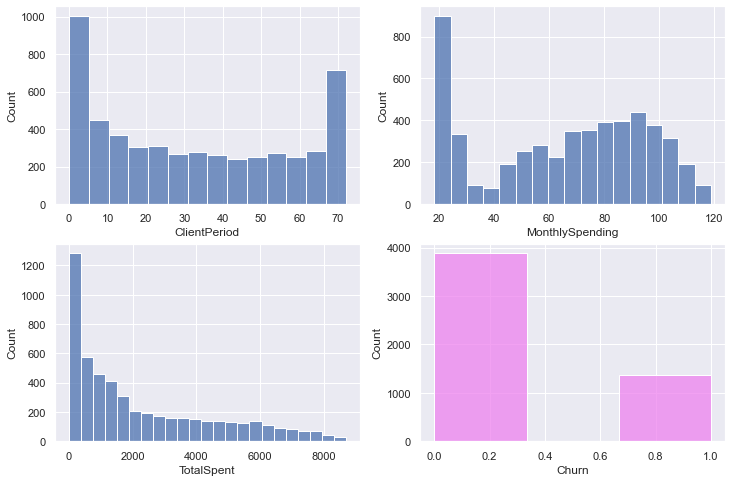

In [18]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(num_cols):
    plt.subplot(2, 2, i+1)
    sns.histplot( x=col, data=data)

plt.subplot(2, 2, 4)
sns.histplot( x='Churn', data=data, color='violet', bins=3);

**Посмотрим на целевую переменную:** 
(сиренево-фиолетовый график). Таки да, классы слегка разбалансированы, ушедших абонентов примерно в три раза меньше, чем остающихся. Но это не тот дисбаланс, к которому надо применять специальные методы обработки.

Видно, что по параметру TotalSpent очень большой разброс. Есть две идеи:
1. Добавить колонку с логарифмом этого параметра (и прибавить 1 для отрыва от нуля), 
2. Разделить его на ClientPeriod.  

Посмотрим оба варианта:

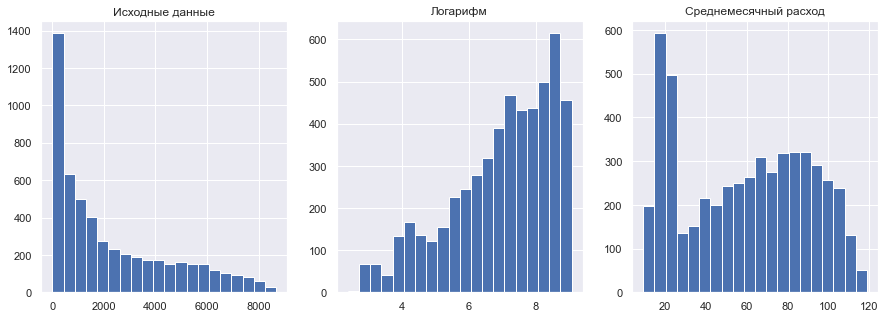

In [19]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)         
plt.hist(data.TotalSpent, bins=20)
plt.title('Исходные данные')           
plt.subplot(1, 3, 2)         
plt.hist(np.log1p(data.TotalSpent), bins=20)
plt.title('Логарифм')           
plt.subplot(1, 3, 3)           
plt.hist(data.TotalSpent/(data.ClientPeriod + 1), bins=20);
plt.title('Среднемесячный расход');

Оба варианта выглядят привлекательно. Поставим эксперимент на простейшей логистической регрессии:

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['Churn'], axis='columns'), data['Churn'], 
                                                    test_size=0.2, random_state=1968)

In [21]:
def lr_try(X_train, X_test, y_train, y_test, num_cols):
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train[num_cols], y_train)
    X_test_s = scaler.transform(X_test[num_cols])

    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore', drop='if_binary')
    X_train_e = ohe.fit_transform(X_train[cat_cols], y_train)
    X_test_e = ohe.transform(X_test[cat_cols])

    # полная матрица
    X_train_trans = np.concatenate([X_train_s, X_train_e], axis=1)
    X_test_trans = np.concatenate([X_test_s, X_test_e], axis=1)

    lr = LogisticRegression()
    lr.fit( X_train_trans, y_train)
    y_train_predict = lr.predict_proba(X_train_trans)
    y_test_predict = lr.predict_proba(X_test_trans)

    return roc_auc_score(y_train, y_train_predict[:,1]), roc_auc_score(y_test, y_test_predict[:,1]) 

#Исходная таблица, baseline

#X_train_s = X_train.copy()

print("ROC_AUC test, train:", * lr_try(X_train, X_test, y_train, y_test, num_cols))

ROC_AUC test, train: 0.8426309932130049 0.871630197972909


In [22]:
#Логарифм

X_train_s, X_test_s = X_train.copy(), X_test.copy()
X_train_s['TotalSpentLog'] = np.log(X_train.TotalSpent)
X_test_s['TotalSpentLog'] = np.log(X_test.TotalSpent)

print("ROC_AUC test, train:", * lr_try(X_train_s, X_test_s, y_train, y_test, num_cols+['TotalSpentLog']))

ROC_AUC test, train: 0.8455306014048732 0.8799374822392726


In [23]:
#Среднемесячный расход

X_train_s, X_test_s = X_train.copy(), X_test.copy()
X_train_s['TotalSpent'] = X_train.TotalSpent / (X_train.ClientPeriod+1)
X_test_s['TotalSpent'] = X_test.TotalSpent / (X_test.ClientPeriod+1)

print("ROC_AUC test, train:", * lr_try(X_train_s, X_test_s, y_train, y_test, num_cols))

ROC_AUC test, train: 0.8428923350542724 0.8753812636165578


**Наилучший вариант - с логарифмом. Но добавим оба! И еще прологарифмируем MonthlySpending**

In [24]:
data['TotalSpentLog'] = np.log(data['TotalSpent']) #добавили параметр TotalSpentLog на его логарифм.
data['MonSpentLog'] = np.log1p(data['MonthlySpending'])
data['TotalSpentMean'] = data.TotalSpent / (data.ClientPeriod+1)
num_cols = list(set(num_cols+['TotalSpentLog', 'MonSpentLog', 'TotalSpentMean']))
num_cols

['TotalSpentLog',
 'TotalSpent',
 'TotalSpentMean',
 'ClientPeriod',
 'MonthlySpending',
 'MonSpentLog']

Ну, и посмотрим корреляцию между признаками.

In [25]:
data.corr()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn,TotalSpentLog,MonSpentLog,TotalSpentMean
ClientPeriod,1.000000,0.246033,0.825869,0.009938,-0.349151,0.832753,0.196349,0.409658
MonthlySpending,0.246033,1.000000,0.651366,0.214500,0.187049,0.574236,0.977437,0.958281
TotalSpent,0.825869,0.651366,1.000000,0.093610,-0.198124,0.832266,0.587052,0.763642
IsSeniorCitizen,0.009938,0.214500,0.093610,1.000000,0.158100,0.098127,0.213164,0.195189
Churn,-0.349151,0.187049,-0.198124,0.158100,1.000000,-0.234945,0.206477,0.070554
TotalSpentLog,0.832753,0.574236,0.832266,0.098127,-0.234945,1.000000,0.544738,0.744649
MonSpentLog,0.196349,0.977437,0.587052,0.213164,0.206477,0.544738,1.000000,0.922333
TotalSpentMean,0.409658,0.958281,0.763642,0.195189,0.070554,0.744649,0.922333,1.000000


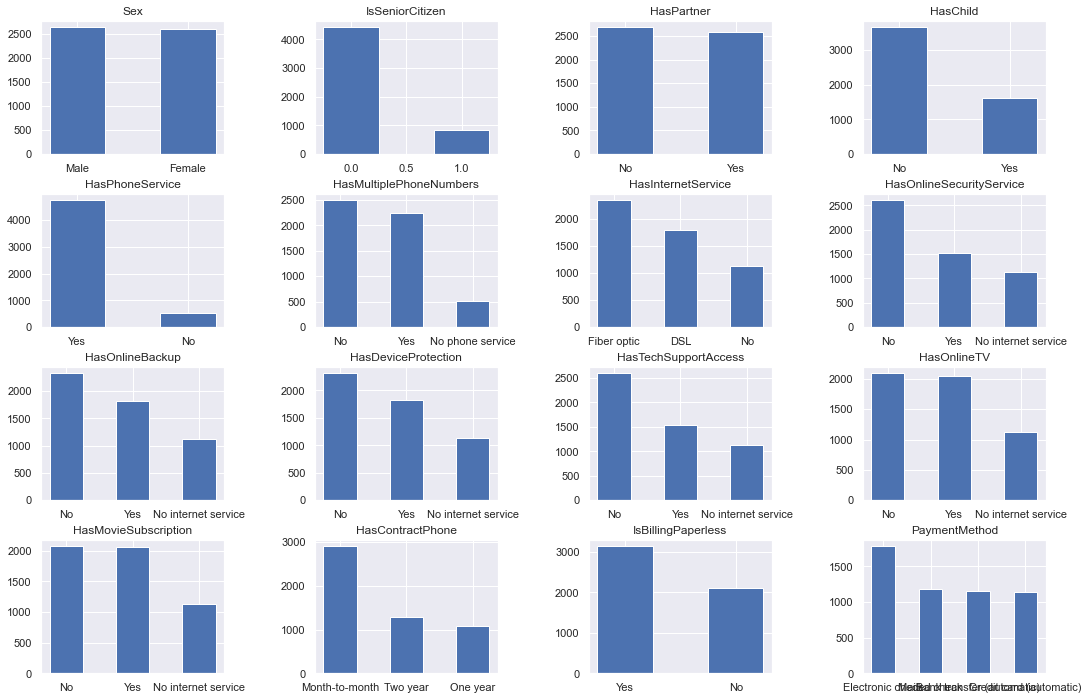

In [26]:
sns.set()

plt.figure(figsize=(18, 12))

for i, col in enumerate(cat_cols):
    plotdata = data[col].value_counts()
    plt.subplot(4, 4, i+1)
    plt.bar(plotdata.index, plotdata.values, width=0.5)
    plt.title(col)
    
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show();    

**На этом этапе ошибок и выбросов также не видно.**

Посмотрим еще зависимость целевого признака от категориальных признаков:

In [27]:
col = cat_cols[3]
pdata = data[data['Churn']==1][col].value_counts() / data[col].value_counts() #.sort_values(ascending=False)
pdata = pdata.sort_values(ascending=False)
pdata

No     0.307882
Yes    0.153176
Name: HasChild, dtype: float64

In [28]:
pdata.sort_values(ascending=False)

No     0.307882
Yes    0.153176
Name: HasChild, dtype: float64

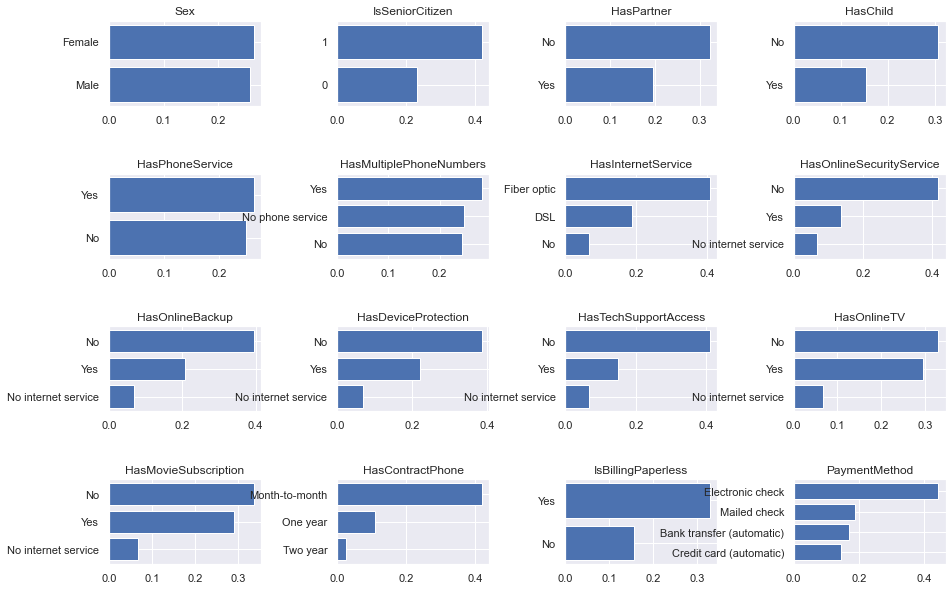

In [29]:
plt.figure(figsize=(15, 10))
    
plt.subplots_adjust(wspace=0.5, hspace=0.8)
for i, col in enumerate(cat_cols):
    pdata=data[data['Churn']==1][col].value_counts() / data[col].value_counts()
    pdata = pdata.sort_values()# (ascending=False)
    plt.subplot(4, 4, i+1)
    plt.barh(pdata.index, width=pdata.values)
    plt.title(col)
    
plt.show();    


Видны категории, в которых процент "отказников" значительно выше: это PaymentMethod:Electronic check, HasContractPhone:Month-to-month, ну и еще пара категорий. Если бы у нас была задача определить, чем клиенты недовольны - надо было бы исследовать дальше в этом направлении.

Уберем неинформативные поля в некоторых признаках:

In [30]:
{col:list(data[col].unique()) for col in cat_cols}

{'Sex': ['Male', 'Female'],
 'IsSeniorCitizen': [0, 1],
 'HasPartner': ['Yes', 'No'],
 'HasChild': ['Yes', 'No'],
 'HasPhoneService': ['Yes', 'No'],
 'HasMultiplePhoneNumbers': ['No', 'Yes', 'No phone service'],
 'HasInternetService': ['No', 'Fiber optic', 'DSL'],
 'HasOnlineSecurityService': ['No internet service', 'No', 'Yes'],
 'HasOnlineBackup': ['No internet service', 'No', 'Yes'],
 'HasDeviceProtection': ['No internet service', 'No', 'Yes'],
 'HasTechSupportAccess': ['No internet service', 'Yes', 'No'],
 'HasOnlineTV': ['No internet service', 'No', 'Yes'],
 'HasMovieSubscription': ['No internet service', 'No', 'Yes'],
 'HasContractPhone': ['One year', 'Two year', 'Month-to-month'],
 'IsBillingPaperless': ['No', 'Yes'],
 'PaymentMethod': ['Mailed check',
  'Credit card (automatic)',
  'Electronic check',
  'Bank transfer (automatic)']}

In [31]:
data = data.replace({'No internet service':'No', 
                    'No phone service':'No'})

**На этом предварительную обработку данных закончим.**

**Хотя можно было бы заняться конструированием новых фичей.**

<a name="2"> </a>
# 2. Загрузка и обработка тестовых данных
<a href="#b"> back </a>

In [32]:
test_data = pd.read_csv(DATAPATH+'test.csv')

In [33]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

In [34]:
#повторяем обработку, примененную для Train
test_data['TotalSpent'] = pd.to_numeric(test_data.TotalSpent.str.strip())
test_data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  2
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
dtype: int64

In [35]:
#заполним половиной месячного расхода
test_data.loc[test_data['TotalSpent'].isna(), 'TotalSpent'] = test_data.loc[test_data['TotalSpent'].isna(), 'MonthlySpending'] /2
test_data[test_data.ClientPeriod == 0]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
177,0,19.85,9.925,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check
767,0,20.25,10.125,Male,0,No,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check


In [36]:
# добавим логирифмированные фичи и среднее
test_data['TotalSpentLog'] = np.log(test_data['TotalSpent'])
test_data['MonSpentLog'] = np.log1p(test_data['MonthlySpending'])
test_data['TotalSpentMean'] = test_data.TotalSpent / (test_data.ClientPeriod+1)

In [37]:
test_data = test_data.replace({'No internet service':'No', 
                    'No phone service':'No'})

In [38]:
test_data.describe()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,TotalSpentLog,MonSpentLog,TotalSpentMean
count,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000,1761.000000
mean,32.293583,64.272601,2256.494520,0.170358,6.917553,4.036474,58.530204
std,24.593736,29.832517,2260.490448,0.376054,1.566571,0.579138,30.304122
min,0.000000,18.550000,9.925000,0.000000,2.295057,2.972975,9.425000
25%,9.000000,35.650000,405.600000,0.000000,6.005367,3.601413,26.750000
50%,29.000000,70.050000,1356.300000,0.000000,7.212516,4.263384,60.550000
75%,56.000000,89.400000,3759.050000,0.000000,8.231922,4.504244,83.944565
max,72.000000,117.350000,8496.700000,1.000000,9.047433,4.773646,116.393151


### Тестовые данные загружены и подготовлены.

<a name="3"> </a>
# 3. Логистическая регрессия
<a href="#b"> back </a>

In [46]:
preproc = ColumnTransformer([
    ('num', StandardScaler(), num_cols), 
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='if_binary'), cat_cols)],
     verbose_feature_names_out = False)

lrmodel = Pipeline(steps=[
    ('enc', preproc), 
    ('alg', LogisticRegression(max_iter=200))
])

params = {
    'alg__C':np.linspace(0.1, 0.2, 20), #np.linspace(0.08, 0.2, 20),
    'alg__penalty':['l1'], #['l1', 'l2'], 
    'alg__solver':['liblinear'] #['lbfgs', 'liblinear', 'saga']
}

lr = GridSearchCV(lrmodel, params, cv=5, verbose=0, n_jobs=-1, scoring='roc_auc')

lr.fit(data.drop(target_col, axis='columns'), data[target_col])
lr.best_params_


{'alg__C': 0.1368421052631579,
 'alg__penalty': 'l1',
 'alg__solver': 'liblinear'}

In [47]:
pd.DataFrame(lr.cv_results_).sort_values(by='mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alg__C,param_alg__penalty,param_alg__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.129108,0.016231,0.017257,0.000496,0.136842,l1,liblinear,"{'alg__C': 0.1368421052631579, 'alg__penalty':...",0.866953,0.845266,0.839862,0.856060,0.838444,0.849317,0.010775,1
3,0.115509,0.024122,0.016729,0.000252,0.115789,l1,liblinear,"{'alg__C': 0.11578947368421053, 'alg__penalty'...",0.866901,0.845932,0.839805,0.855703,0.838224,0.849313,0.010723,2
4,0.127244,0.020519,0.020529,0.002718,0.121053,l1,liblinear,"{'alg__C': 0.12105263157894737, 'alg__penalty'...",0.866868,0.845730,0.839805,0.855858,0.838294,0.849311,0.010730,3
6,0.119491,0.018873,0.017683,0.000618,0.131579,l1,liblinear,"{'alg__C': 0.13157894736842107, 'alg__penalty'...",0.866901,0.845383,0.839819,0.856036,0.838322,0.849292,0.010779,4
5,0.116114,0.017675,0.016935,0.000914,0.126316,l1,liblinear,"{'alg__C': 0.12631578947368421, 'alg__penalty'...",0.866859,0.845571,0.839791,0.855966,0.838252,0.849288,0.010762,5


In [48]:
y_train_predict = lr.predict_proba(data.drop(target_col, axis='columns'))
y_test_predict = lr.predict_proba(test_data)

roc_auc_score(data[target_col], y_train_predict[:,1]), 

(0.8523369791810264,)

In [49]:
submit = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/submission.csv', index_col='Id')

submit['Churn'] = y_test_predict[:,1]

submit.to_csv('submission.csv')

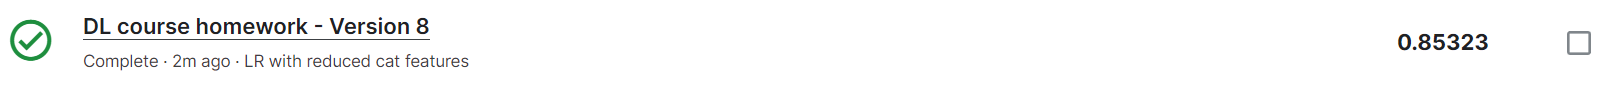

**Kaggle 0.85323**

In [107]:
preproc = ColumnTransformer([
    ('num', PCA(), num_cols), 
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='if_binary'), cat_cols)],
     verbose_feature_names_out = False)

lrmodel = Pipeline(steps=[
    ('enc', preproc), 
    ('alg', LogisticRegression(max_iter=200))
])

params = {
    'alg__C': [25], #np.linspace(10, 40, 10),
    'alg__penalty':['l1'], # 'l2'], 
    'alg__solver':['liblinear'], #'saga', #'lbfgs', 
    'enc__num__n_components': [5]
}

lr = GridSearchCV(lrmodel, params, cv=5, verbose=0, n_jobs=-1, scoring='roc_auc')

lr.fit(data.drop(target_col, axis='columns'), data[target_col])
lr.best_params_

{'alg__C': 25,
 'alg__penalty': 'l1',
 'alg__solver': 'liblinear',
 'enc__num__n_components': 5}

In [108]:
pd.DataFrame(lr.cv_results_).sort_values(by='mean_test_score', ascending=False).iloc[:5, [4, 5, 6, 7, 14]]

,param_alg__C,param_alg__penalty,param_alg__solver,param_enc__num__n_components,mean_test_score
0,25,l1,liblinear,5,0.849042


In [109]:
y_train_predict = lr.predict_proba(data.drop(target_col, axis='columns'))
y_test_predict = lr.predict_proba(test_data)

roc_auc_score(data[target_col], y_train_predict[:,1]), 

(0.8531225459829,)

In [110]:
submit = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/submission.csv', index_col='Id')

submit['Churn'] = y_test_predict[:,1]

submit.to_csv('submission_pca.csv')

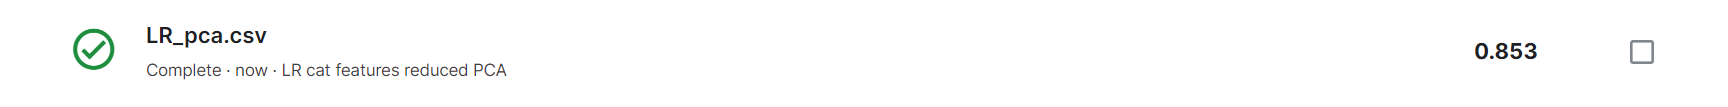

<a name="4"> </a>
# 4. Лес решающих деревьев
<a href="#b"> back </a>

In [53]:
preproc = ColumnTransformer([
    ('num', 'passthrough', num_cols), 
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='if_binary'), cat_cols)],
     verbose_feature_names_out = False)

rfmodel = Pipeline(steps=[
    ('enc', preproc), 
    ('alg', RandomForestClassifier())
])

params = {
    'alg__n_estimators': [300], #[100],
    'alg__max_depth': [6], #np.arange(3, 20),
    'alg__criterion':['entropy'], #['gini', 'entropy'],
    #'alg__min_samples_split': np.arange(2, 10), 
    #'alg__min_samples_leaf': np.arange(1, 10)
}

rf = RandomizedSearchCV(rfmodel, params, cv=5, verbose=10, n_jobs=-1, scoring='roc_auc', n_iter=200)
# rf = GridSearchCV(rfmodel, params, cv=5, verbose=10, n_jobs=-1, scoring='roc_auc')

rf.fit(data.drop(target_col, axis='columns'), data[target_col])

Fitting 5 folds for each of 1 candidates, totalling 5 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('enc',
                                              ColumnTransformer(transformers=[('num',
                                                                               'passthrough',
                                                                               ['MonthlySpending',
                                                                                'TotalSpentLog',
                                                                                'ClientPeriod',
                                                                                'MonSpentLog',
                                                                                'TotalSpent',
                                                                                'TotalSpentMean']),
                                                                              ('cat',
                                                                           

In [54]:
pd.DataFrame(rf.cv_results_).sort_values(by='mean_test_score', ascending=False)['mean_test_score'].head()

0    0.842843
Name: mean_test_score, dtype: float64

In [55]:
y_train_predict = rf.predict_proba(data.drop(target_col, axis='columns'))
y_test_predict = rf.predict_proba(test_data)

roc_auc_score(data[target_col], y_train_predict[:,1]), 

(0.8737553731662685,)

In [56]:
submit = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/submission.csv', index_col='Id')

submit['Churn'] = y_test_predict[:,1]

submit.to_csv('rf_cat_feat_reduced.csv')

**Kaggle показал 0.85353 (было 0.85198 с одним логарифмом)**

<a name="5"> </a>
# 5. Градиентный бустинг

<a href="#b"> back </a><br>

In [39]:
from catboost import CatBoostClassifier, Pool, cv

datapool = Pool(data=data.drop(target_col, axis='columns'), label=data[target_col], cat_features=cat_cols)

In [40]:
%%time 

fix_params = {"iterations": 100,
              "loss_function": "Logloss",
              "custom_loss": "AUC:hints=skip_train~false",
              'eval_metric': 'AUC:hints=skip_train~false',
              "verbose": 0,
             #'task_type':'GPU'
             }

params = {"depth": [3], #np.arange(2, 10), #[2, 3, 4, 5],
          'learning_rate': [0.08], #np.linspace(0.03, 0.8, 8),
          'l2_leaf_reg': [3.75], #np.linspace(3, 4, 6),
          'min_data_in_leaf': [1], #np.arange(1, 10, 2), 
          #'grow_policy': ['Depthwise'] #['SymmetricTree', 'Depthwise', 'Lossguide']
          }


cat = CatBoostClassifier(**fix_params)
scores = cat.grid_search(params, datapool, cv=3)
#scores = cat.randomized_search(params, datapool, cv=4, n_iter=100)



bestTest = 0.8682133605
bestIteration = 97

0:	loss: 0.8682134	best: 0.8682134 (0)	total: 1.3s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 0.8360422723
bestIteration = 98

Training on fold [1/3]

bestTest = 0.8520215374
bestIteration = 99

Training on fold [2/3]

bestTest = 0.8504479361
bestIteration = 88

CPU times: total: 19.5 s
Wall time: 6.08 s


In [41]:
scores['params']

{'min_data_in_leaf': 1, 'depth': 3, 'learning_rate': 0.08, 'l2_leaf_reg': 3.75}

In [42]:
fix_params['iterations'] = 300
cat_res = CatBoostClassifier(**fix_params, **scores['params'])
cat_res.fit(datapool)
roc_auc_score(data[target_col], cat_res.predict_proba(datapool)[:,1])

0.8704838817671793

In [43]:
submit = pd.read_csv(DATAPATH+'submission.csv', index_col='Id')

submit['Churn'] = cat_res.predict_proba(test_data)[:,1]

submit.to_csv('cb_new_new.csv')

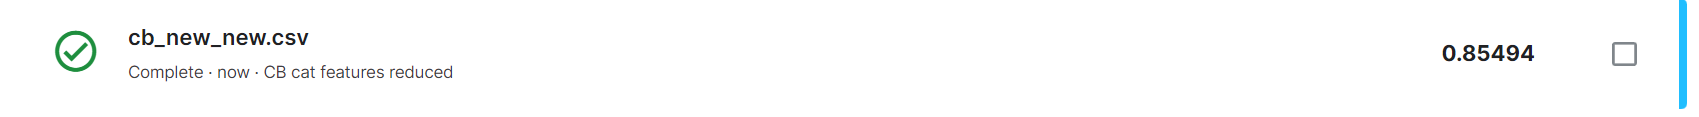

**Kaggle дал 0.85494**

85 результат на 09.03.2023

<a name="6"> </a>    
# Финальный результат

**Лучший результат на Kaggle в этой версии дал CatBoost - 0.85494**

<a href=#5> ссылка на раздел </a>